In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import xgboost as xgb
from sklearn.metrics import mean_squared_log_error
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV

# Data Preprocessing:

In [2]:
raw=pd.read_csv("train.csv")

In [3]:
raw.shape

(1458644, 11)

In [4]:
raw.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
def rush_hour_f(row):
    r_hour=row["real_hour"]
    if (6<r_hour) & (r_hour<=10):
        return 1
    if (10<r_hour) & (r_hour<=16):
        return 2
    if (16<r_hour) & (r_hour<=20):
        return 3
    return 0
    

In [6]:
raw["pickup_datetime"]=pd.to_datetime(raw["pickup_datetime"])

In [7]:
raw["month"]=raw["pickup_datetime"].dt.month
raw["week"]=raw["pickup_datetime"].dt.week
raw["weekday"]=raw["pickup_datetime"].dt.weekday
raw["hour"]=raw["pickup_datetime"].dt.hour
raw["minute"]=raw["pickup_datetime"].dt.minute
raw["minuteoftheday"]=raw["hour"]*60 + raw["minute"]
raw["real_hour"]=raw["minuteoftheday"]/60

C:\Users\Hp\AppData\Local\Temp/ipykernel_1900/2806244367.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  raw["week"]=raw["pickup_datetime"].dt.week


In [8]:
raw["rush_hour"]=raw.apply(rush_hour_f,axis=1)
raw["is_weekend"]=raw["weekday"] > 4

In [9]:
raw.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month,week,weekday,hour,minute,minuteoftheday,real_hour,rush_hour,is_weekend
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,3,11,0,17,24,1044,17.400000,3,False
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,23,6,0,43,43,0.716667,0,True
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,3,1,11,35,695,11.583333,2,False
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,4,14,2,19,32,1172,19.533333,3,False
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,3,12,5,13,30,810,13.500000,2,True


In [10]:
data=raw.drop(["id","pickup_datetime","dropoff_datetime","hour","minute"],axis=1)

In [11]:
data.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month,week,weekday,minuteoftheday,real_hour,rush_hour,is_weekend
0,2,1,-73.982155,40.767937,-73.964630,40.765602,N,455,3,11,0,1044,17.400000,3,False
1,1,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,23,6,43,0.716667,0,True
2,2,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,3,1,695,11.583333,2,False
3,2,1,-74.010040,40.719971,-74.012268,40.706718,N,429,4,14,2,1172,19.533333,3,False
4,2,1,-73.973053,40.793209,-73.972923,40.782520,N,435,3,12,5,810,13.500000,2,True


In [12]:
from math import radians, cos, sin, asin, sqrt

In [13]:
def haversine(row):
    lon1 = row['pickup_longitude']
    lat1 = row['pickup_latitude']
    lon2 = row['dropoff_longitude']
    lat2 = row['dropoff_latitude']
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6369 * c
    return km

In [14]:
data["distance"]=data.apply(haversine,axis=1)

In [15]:
data.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month,week,weekday,minuteoftheday,real_hour,rush_hour,is_weekend,distance
0,2,1,-73.982155,40.767937,-73.964630,40.765602,N,455,3,11,0,1044,17.400000,3,False,1.498050
1,1,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,23,6,43,0.716667,0,True,1.804940
2,2,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,3,1,695,11.583333,2,False,6.383094
3,2,1,-74.010040,40.719971,-74.012268,40.706718,N,429,4,14,2,1172,19.533333,3,False,1.485032
4,2,1,-73.973053,40.793209,-73.972923,40.782520,N,435,3,12,5,810,13.500000,2,True,1.188215


In [16]:
clean_up={"store_and_fwd_flag":{"N":0,"Y":1},
          "is_weekend":{False:0,True:1}}

In [17]:
data=data.replace(clean_up)

In [18]:
import statsmodels.api as sm

In [19]:
X=data.drop(columns=["trip_duration"])
y=data["trip_duration"]
X=sm.add_constant(X)

C:\Users\Hp\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [20]:
X.head()

,const,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,month,week,weekday,minuteoftheday,real_hour,rush_hour,is_weekend,distance
0,1.0,2,1,-73.982155,40.767937,-73.964630,40.765602,0,3,11,0,1044,17.400000,3,0,1.498050
1,1.0,1,1,-73.980415,40.738564,-73.999481,40.731152,0,6,23,6,43,0.716667,0,1,1.804940
2,1.0,2,1,-73.979027,40.763939,-74.005333,40.710087,0,1,3,1,695,11.583333,2,0,6.383094
3,1.0,2,1,-74.010040,40.719971,-74.012268,40.706718,0,4,14,2,1172,19.533333,3,0,1.485032
4,1.0,2,1,-73.973053,40.793209,-73.972923,40.782520,0,3,12,5,810,13.500000,2,1,1.188215


In [21]:
y

0           455
1           663
2          2124
3           429
4           435
           ... 
1458639     778
1458640     655
1458641     764
1458642     373
1458643     198
Name: trip_duration, Length: 1458644, dtype: int64

In [22]:
log_y=np.log(y)

In [23]:
log_y

0          6.120297
1          6.496775
2          7.661056
3          6.061457
4          6.075346
             ...   
1458639    6.656727
1458640    6.484635
1458641    6.638568
1458642    5.921578
1458643    5.288267
Name: trip_duration, Length: 1458644, dtype: float64

In [24]:
from sklearn.model_selection import train_test_split
X_train,x_test,y_train,y_test=train_test_split(X,log_y,test_size=0.2,random_state=3)

# Linear Regression:

In [35]:
results=sm.OLS(y_train,X_train).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     817.0
Date:                Thu, 07 Jul 2022   Prob (F-statistic):               0.00
Time:                        11:37:42   Log-Likelihood:            -1.1666e+07
No. Observations:             1166915   AIC:                         2.333e+07
Df Residuals:                 1166900   BIC:                         2.333e+07
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.146e+05   1.02

In [42]:
def lm_stat(X,y,y_pred):
    try: 
        y.shape[1] == 1
        # take first dimension as vector
        y = y.iloc[:,0]
    except:
        pass
    y = np.array(y)
    
    #Residuals
    residuals=np.array(y-y_pred)
    
    #Hat_matrix:
    H = np.dot(np.array(np.dot(X , np.linalg.inv(np.dot(X.T , X)))) , X.T)
    
    #leverage:
    h_ii=H.diagonal()
    
    #Externalised studentised residual:
    
    # Estimate variance (externalised)
     # Estimate variance (externalised)
    σi_est = []
    for i in range(X.shape[0]):
        # exclude ith observation from estimation of variance
        external_residuals = np.delete(residuals, i)
        σi_est += [np.sqrt((1 / (X.shape[0] - X.shape[1] - 1)) * np.sum(np.square(external_residuals)))]
    σi_est = np.array(σi_est)
    
    # Externally studentised residuals
    t = residuals / σi_est * np.sqrt(1 - h_ii)
    
     # Return dataframe
    return pd.DataFrame({'residual': residuals,
                         'leverage': h_ii, 
                         'studentised_residual': t,
                         'y_pred': y_pred})

In [43]:
y_pred=results.predict(X_train)
X_train=np.array(X_train)

In [51]:
influence = results.get_influence()
leverage = influence.hat_matrix_diag
residuals=np.array(y_train-y_pred)
standardized_residuals = influence.resid_studentized_internal

In [52]:
import seaborn as sns

## Residual Plot:

In [58]:
standardized_residuals[standardized_residuals>100]=0
y_pred[y_pred>20000]=20000

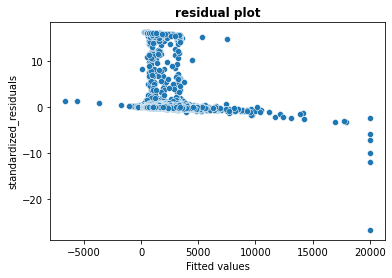

In [59]:
ax=sns.scatterplot(x=y_pred,y=standardized_residuals)
plt.xlabel('Fitted values')
plt.ylabel('standardized_residuals')
plt.title('residual plot', fontweight='bold');

#### From the above residual plot it is clear that there is a strong non-linear relationship between the predictor and responce.

## Leverage vs Residual:

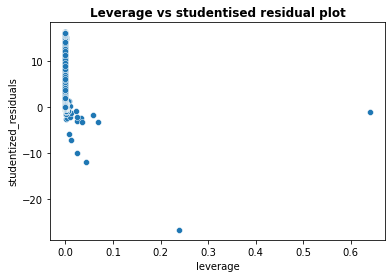

In [60]:
ax=sns.scatterplot(x=leverage,y=standardized_residuals)
plt.xlabel('leverage')
plt.ylabel('studentized_residuals')
plt.title('Leverage vs studentised residual plot', fontweight='bold');

In [19]:
data1=data.copy()

In [20]:
data1.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month,week,weekday,minuteoftheday,real_hour,rush_hour,is_weekend,distance
0,2,1,-73.982155,40.767937,-73.964630,40.765602,0,455,3,11,0,1044,17.400000,3,0,1.498050
1,1,1,-73.980415,40.738564,-73.999481,40.731152,0,663,6,23,6,43,0.716667,0,1,1.804940
2,2,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,1,3,1,695,11.583333,2,0,6.383094
3,2,1,-74.010040,40.719971,-74.012268,40.706718,0,429,4,14,2,1172,19.533333,3,0,1.485032
4,2,1,-73.973053,40.793209,-73.972923,40.782520,0,435,3,12,5,810,13.500000,2,1,1.188215


In [21]:
def find_outliers(col):
    z=np.abs(stats.zscore(col))
    idx_outliers=np.where(z>3,True,False)
    return pd.Series(idx_outliers,index=col.index)

In [22]:
data_outliers=pd.DataFrame()
for col in data1.describe().columns:
    data_outliers[col]=find_outliers(data1[col])

In [23]:
test_outs=data_outliers.apply(lambda x:np.any(x),axis=1)

In [24]:
(np.sum(test_outs)/data.shape[0])*100

9.118948831928833

#### From above,we can see dataset contains more than 9% outliers.It will be a huge information loss if we remove these datapoints from our training set.I have decided to use tree based methods since they are robust to outliers.

## Decision Tree :

In [24]:
from sklearn.tree import DecisionTreeRegressor

In [23]:
model=DecisionTreeRegressor(random_state=2)
model.fit(X_train,y_train)

DecisionTreeRegressor(random_state=2)

In [24]:
#Training Error
print(model.score(X_train,y_train))

#Test Error
print(model.score(x_test,y_test))

1.0
-0.5132195130806525


In [25]:
y_pred_train=model.predict(X_train)
y_pred_test=model.predict(x_test)

In [33]:
from sklearn.metrics import mean_squared_log_error

In [27]:
#Training error
print(np.sqrt(mean_squared_log_error(y_train, y_pred_train)))

#Test error
print(np.sqrt(mean_squared_log_error(y_test, y_pred_test)))

0.0
0.5927991930154244


In [30]:
print(model.get_depth())

65


In [31]:
print(model.get_n_leaves())

1158240


In [44]:
from sklearn.model_selection import  GridSearchCV

In [55]:
m_depth=[20,15,10]
train_error=[]
test_error=[]
for i in m_depth:
    model=DecisionTreeRegressor(max_depth=i,random_state=0)
    model.fit(X_train,y_train)
    y_pred_train=model.predict(X_train)
    y_pred_test=model.predict(x_test)
    train_error.append(np.sqrt(mean_squared_log_error(y_train, y_pred_train)))
    test_error.append(np.sqrt(mean_squared_log_error(y_test, y_pred_test)))
    

In [56]:
train_error

[0.43726432742477, 0.520559801552856, 0.5667834440458854]

In [57]:
test_error

[0.547195656977285, 0.5546613946841035, 0.5720884286784601]

In [25]:
model=DecisionTreeRegressor(max_depth=20,random_state=0)

In [26]:
from sklearn.model_selection import cross_val_score

In [28]:
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_log_error')

In [31]:
scores=np.sqrt(np.abs(np.array(scores)))

#### Estimated error for decision tree after tunning:

In [33]:
scores.mean()

0.5448897076602084

# Random Forest:

In [22]:
from sklearn.ensemble import RandomForestRegressor

In [25]:
regr=RandomForestRegressor(n_estimators=20,random_state=0)

In [26]:
regr.fit(X_train,y_train)

RandomForestRegressor(n_estimators=20, random_state=0)

In [28]:
y_pred_train=regr.predict(X_train)
y_pred_test=regr.predict(x_test)

In [31]:
# training error
print(np.sqrt(mean_squared_log_error(y_train, y_pred_train)))

0.3100378067612447


In [32]:
#testing error
print(np.sqrt(mean_squared_log_error(y_test, y_pred_test)))

0.5744315978472634


## XGboost:

In [25]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(x_test, label=y_test)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Try different parameters! My favorite is random search :)
xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': 4, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

In [26]:
model_xgb = xgb.train(xgb_pars, dtrain, 500, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)

C:\Users\Hp\anaconda3\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[16:12:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:4.24109	valid-rmse:4.23907
[10]	train-rmse:0.52650	valid-rmse:0.53115
[20]	train-rmse:0.46837	valid-rmse:0.47686
[30]	train-rmse:0.44292	valid-rmse:0.45446
[40]	train-rmse:0.43177	valid-rmse:0.44555
[50]	train-rmse:0.42365	valid-rmse:0.44030
[60]	train-rmse:0.42063	valid-rmse:0.43858
[70]	train-rmse:0.41446	valid-rmse:0.43457
[80]	train-rmse:0.40767	valid-rmse:0.42923
[90]	train-rmse:0.4026

In [27]:
D_X_train=xgb.DMatrix(X_train)
D_x_test=xgb.DMatrix(x_test)
D_y_train=xgb.DMatrix(y_train)
D_y_test=xgb.DMatrix(y_test)

In [28]:
y_pred_train=model_xgb.predict(D_X_train)
y_pred_test=model_xgb.predict(D_x_test)

In [29]:
y_pred_train=np.exp(y_pred_train)
y_pred_test=np.exp(y_pred_test)

In [30]:
y_pred_train

array([ 711.2352 ,  949.7953 ,  577.05597, ..., 1558.8024 , 1332.8948 ,
        896.24384], dtype=float32)

In [31]:
y_pred_train[y_pred_train < 0]=0

In [32]:
y_pred_test[y_pred_test < 0]=0

In [33]:
y_train=np.exp(y_train)
y_test=np.exp(y_test)

In [34]:
# training error
print("Training Error: ",np.sqrt(mean_squared_log_error(y_train, y_pred_train)))

#testing error
print("Testing Error: ",np.sqrt(mean_squared_log_error(y_test, y_pred_test)))

Training Error:  0.3728001319927752
Testing Error:  0.4110506608525764


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

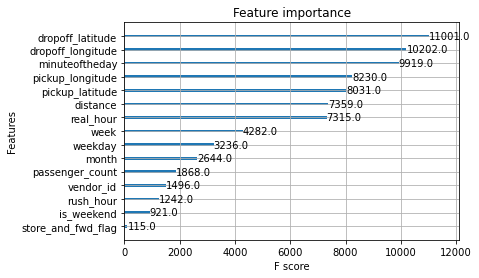

In [35]:
xgb.plot_importance(model_xgb)

### Training Final Model With Full Dataset For Final Submission

In [54]:
dtrainf=xgb.DMatrix(X,label=log_y)
model_xgb = xgb.train(xgb_pars, dtrainf, 264, maximize=False, verbose_eval=10)

[18:46:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[18:46:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [40]:
X_testf=pd.read_csv('test.csv')

In [41]:
X_testf.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [43]:
X_testf["pickup_datetime"]=pd.to_datetime(X_testf["pickup_datetime"])

X_testf["month"]=X_testf["pickup_datetime"].dt.month
X_testf["week"]=X_testf["pickup_datetime"].dt.week
X_testf["weekday"]=X_testf["pickup_datetime"].dt.weekday
X_testf["hour"]=X_testf["pickup_datetime"].dt.hour
X_testf["minute"]=X_testf["pickup_datetime"].dt.minute
X_testf["minuteoftheday"]=X_testf["hour"]*60 + X_testf["minute"]
X_testf["real_hour"]=X_testf["minuteoftheday"]/60

X_testf["rush_hour"]=X_testf.apply(rush_hour_f,axis=1)
X_testf["is_weekend"]=X_testf["weekday"] > 4

C:\Users\Hp\AppData\Local\Temp/ipykernel_1900/143237962.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  X_testf["week"]=X_testf["pickup_datetime"].dt.week


In [44]:
X_testf=X_testf.drop(["id","pickup_datetime","hour","minute"],axis=1)

X_testf["distance"]=X_testf.apply(haversine,axis=1)

clean_up={"store_and_fwd_flag":{"N":0,"Y":1},
          "is_weekend":{False:0,True:1}}
X_testf=X_testf.replace(clean_up)

X_testf=sm.add_constant(X_testf)

C:\Users\Hp\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [47]:
X_testf.head()

,const,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,month,week,weekday,minuteoftheday,real_hour,rush_hour,is_weekend,distance
0,1.0,1,1,-73.988129,40.732029,-73.990173,40.756680,0,6,26,3,1439,23.983333,0,0,2.745564
1,1.0,1,1,-73.964203,40.679993,-73.959808,40.655403,0,6,26,3,1439,23.983333,0,0,2.758373
2,1.0,1,1,-73.997437,40.737583,-73.986160,40.729523,0,6,26,3,1439,23.983333,0,0,1.305745
3,1.0,2,1,-73.956070,40.771900,-73.986427,40.730469,0,6,26,3,1439,23.983333,0,0,5.267434
4,1.0,1,1,-73.970215,40.761475,-73.961510,40.755890,0,6,26,3,1439,23.983333,0,0,0.960540


In [59]:
D_X_testf=xgb.DMatrix(X_testf)
final_pred=model_xgb.predict(D_X_testf)

In [60]:
final_pred=np.exp(np.array(final_pred))

In [61]:
final_pred

array([ 866.51227,  506.72607,  426.72302, ..., 2008.6554 , 1824.2739 ,
       1185.7404 ], dtype=float32)

In [66]:
test_data=pd.read_csv('test.csv')
customer_id=test_data["id"]

In [70]:
df=pd.DataFrame({'id':customer_id,'trip_duration':final_pred})
df.to_csv('submission.csv',index=False)